# Lesson 1: Exercises

## Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [ ]:
%run ../utils.ipynb

## Model template

In order to reduce the required typing, we create a template that returns a pre-configured model s.t. we only need to specify the sections.

In [ ]:
# Do not delete!
def create_model_template(n_comp=1):
    # Auxiliary variables
    Q = 1

    model = get_cadet_template(n_units=2)
    
    # Inlet
    model.root.input.model.unit_000.unit_type = 'INLET'
    model.root.input.model.unit_000.ncomp = n_comp
    model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'
    
    # Outlet
    model.root.input.model.unit_001.unit_type = 'OUTLET'
    model.root.input.model.unit_001.ncomp = n_comp
    
    model.root.input.model.connections.nswitches = 1
    model.root.input.model.connections.switch_000.section = 0
    model.root.input.model.connections.switch_000.connections = [
        0, 1, -1, -1, Q, # unit_000, unit_001, all components, all components, Q/ L/min
        ]
    
    return model

def plot_results(model):
    plt.figure()

    time = model.root.output.solution.solution_times
    c = model.root.output.solution.unit_001.solution_inlet
    plt.plot(time, c)
    plt.xlabel('$time~/~min$')
    plt.ylabel('$Outlet~concentration~/~mol \cdot L^{-1} $')
    plt.show()

## Exercise 1

Create the following inlet profile:

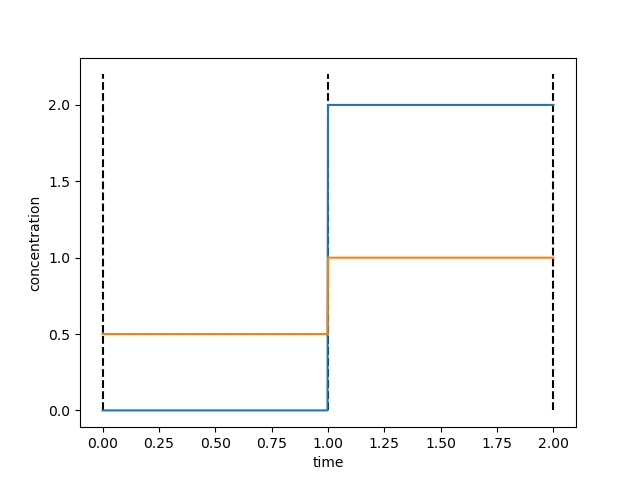

***Hint:*** We need to specify a second component for the template function and then pass a list of concentrations to the coefficient parameters.

In [ ]:
model = create_model_template(n_comp=2)

model.root.input.solver.sections.nsec = 2
model.root.input.solver.sections.section_times = [0.0, 1.0, 2.0,]    # min
model.root.input.solver.sections.section_continuity = [0, 0,]

model.root.input.model.unit_000.sec_000.const_coeff = [0.0, 0.5,]    # mol / m^3
model.root.input.model.unit_000.sec_001.const_coeff = [2.0, 1.0,]    # mol / m^3

model.root.input.solver.user_solution_times = np.linspace(0, 2.0, 1001)

run_simulation(model)
plot_results(model)

## Exercise 2

Create the following inlet profile:

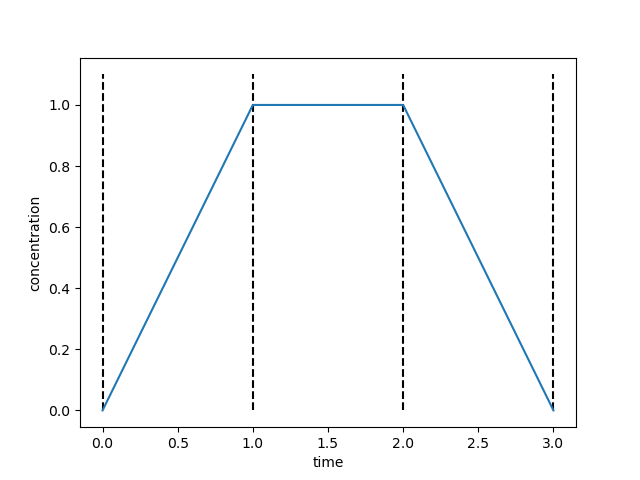

***Hint:*** We need three sections, and for linear gradients, the `lin_coeff` parameter needs to be modified.

In [ ]:
model = create_model_template(n_comp=1)

model.root.input.solver.sections.nsec = 3
model.root.input.solver.sections.section_times = [0.0, 1.0, 2.0, 3.0] # min
model.root.input.solver.sections.section_continuity = [0, 0, 0]

model.root.input.model.unit_000.sec_000.const_coeff = [0.0,]    # mol / m^3
model.root.input.model.unit_000.sec_000.lin_coeff = [1.0,]      # mol / m^3 / min

model.root.input.model.unit_000.sec_001.const_coeff = [1.0,]    # mol / m^3
model.root.input.model.unit_000.sec_001.lin_coeff = [0.0,]      # mol / m^3 / min

model.root.input.model.unit_000.sec_002.const_coeff = [1.0,]    # mol / m^3
model.root.input.model.unit_000.sec_002.lin_coeff = [-1.0,]     # mol / m^3 / min

model.root.input.solver.user_solution_times = np.linspace(0, 3.0, 1001)

run_simulation(model)
plot_results(model)

## Bonus Exercise: Changing the system connectivity

Instead of creating inlet profiles by modifying the concentration profile of an `INLET` unit operation, the same effect can also be achieved by assuming multiple `INLET` with a constant concentration and changing the connectivity of the system.

***Task:*** Try creating a system with a second `INLET` and recreate the previous examples.

In [ ]:
# Do not delete!
def create_dynflow_template(n_comp=1, enable_dynflow=False):
    model = get_cadet_template(n_units=3)
    
    # Inlet 0
    model.root.input.model.unit_000.unit_type = 'INLET'
    model.root.input.model.unit_000.ncomp = n_comp
    model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'
    
    # Inlet 1
    model.root.input.model.unit_001.unit_type = 'INLET'
    model.root.input.model.unit_001.ncomp = n_comp
    model.root.input.model.unit_001.inlet_type = 'PIECEWISE_CUBIC_POLY'
    
    # Outlet
    model.root.input.model.unit_002.unit_type = 'OUTLET'
    model.root.input.model.unit_002.ncomp = n_comp
    
    # Enable dynflow
    if enable_dynflow:
        model.root.input.model.connections.connections_include_dynamic_flow = 1
       
    return model

def plot_dynflow_results(model):
    plt.figure()

    time = model.root.output.solution.solution_times
    c = model.root.output.solution.unit_002.solution_inlet
    plt.plot(time, c)
    plt.xlabel('$time~/~min$')
    plt.ylabel('$Outlet~concentration~/~mol \cdot L^{-1} $')
    plt.show()

### Example 1

In [ ]:
model = create_dynflow_template(n_comp=2)

model.root.input.solver.sections.nsec = 2
model.root.input.solver.sections.section_times = [0.0, 1.0, 2.0] # min
model.root.input.solver.sections.section_continuity = [0, 0]

model.root.input.model.unit_000.sec_000.const_coeff = [0.0, 0.5]    # mol / m^3
model.root.input.model.unit_001.sec_000.const_coeff = [2.0, 1.0]    # mol / m^3

model.root.input.solver.user_solution_times = np.linspace(0, 2.0, 1001)

model.root.input.model.connections.nswitches = 2
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = [
    0, 2, -1, -1, 1,
    1, 2, -1, -1, 0,
    ]

model.root.input.model.connections.switch_001.section = 1
model.root.input.model.connections.switch_001.connections = [
    0, 2, -1, -1, 0,
    1, 2, -1, -1, 1,
    ]

run_simulation(model)
plot_dynflow_results(model)

### Example 2

<div class="alert alert-info">

**Note:** 

Dynamic flow rates require CADET version >=4.1
    
</div>

For modelling gradients using this approach, we need to enable [dynamic flow rates](https://cadet.github.io/interface/system.html#group-input-model-connections-switch-xxx) in the `/input/model/connections/` group. This allows defining the flow rate as a cubic function of time. 

Then, the columns of the connections matrix are:

    [UnitOpID from, UnitOpID to, Component from, Component to, volumetric flow rate, linear flow rate coefficient, quadratic flow rate coefficient, cubic flow rate coefficient]

In [ ]:
model = create_dynflow_template(n_comp=1, enable_dynflow=True)

model.root.input.solver.sections.nsec = 3
model.root.input.solver.sections.section_times = [0.0, 1.0, 2.0, 3.0] # min
model.root.input.solver.sections.section_continuity = [0, 0, 0]

model.root.input.model.unit_000.sec_000.const_coeff = [0.0]    # mol / m^3
model.root.input.model.unit_001.sec_000.const_coeff = [1.0]    # mol / m^3

model.root.input.solver.user_solution_times = np.linspace(0, 3.0, 1001)

model.root.input.model.connections.nswitches = 3
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = [
    0, 2, -1, -1, 1, -1.0, 0, 0,
    1, 2, -1, -1, 0, 1.0, 0, 0,
    ]

model.root.input.model.connections.switch_001.section = 1
model.root.input.model.connections.switch_001.connections = [
    1, 2, -1, -1, 1.0, 0, 0, 0,
    ]

model.root.input.model.connections.switch_002.section = 2
model.root.input.model.connections.switch_002.connections = [
    0, 2, -1, -1, 0, 1.0, 0, 0,
    1, 2, -1, -1, 1.0, -1.0, 0, 0,
    ]

run_simulation(model)
plot_dynflow_results(model)